# Data Cleaning/Preprocessing

In this notebook, we perform inital data cleaning/preprocessing and initial EDA for the final year project.

The preprocessed data is then exported to be used in the subsequent notebooks.

Update:
- Separated the data preprocess and EDA into different notebooks

## 1. Import Packages & Data

**df** is weather observations as obtained from Dublin Airport.

**gsa** contains the hourly average direct normal irradiation, computed for each month. DNI is essebtially the amount of solar radiation recieved by the earth's surface in a specific area, in our case we include DNI in the Dublin Airport region

In [ ]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.2.1

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 24.0 MB/s eta 0:00:00


In [1]:
# data wrangling
import pandas as pd
import numpy as np
from collections import Counter
import missingno

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# other
from tqdm import tqdm
import os
import sys
seed=42

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# importing data and helper functions from directories dependent on which is available

joseph_path = '/content/drive/My Drive/DS_Modules/CA4021 (Final Year Project)/' # Joseph
julita_path = '/content/drive/My Drive/CA4021 (Final Year Project)/' # Julita

if os.path.exists(joseph_path):
  print("Importing from DS_Modules/CA4021")
  sys.path.append(os.path.join(joseph_path, 'scripts'))
  path = joseph_path

elif os.path.exists(julita_path):
  print("Importing directly from CA4021 folder")
  sys.path.append(sys.path.append(os.path.join(julita_path, 'scripts')))
  path = julita_path

Importing from DS_Modules/CA4021


In [4]:
# import helper functions from aux file (prevents too much function definitions in the notebook)
from aux_functions import missing_percentages, plot_dist_discrete, plot_dist_continuous, \
plot_vis_discrete, plot_vis_continuous, month_vplot

from aux_functions_ml import preprocess, manual_cross_validate, get_feat_importance_df, \
performance_report, calc_mean_importance, plot_importance, heidke_skill_score, score_model, display_scores


In [5]:
# import data
df = pd.read_csv(os.path.join(path, 'data/Dublin2011_2021Raw.csv'))  # weather data
gsa = pd.read_excel(os.path.join(path, 'data/GSA_Report_Airport ED.xlsx'), 
                    sheet_name='hourly_profiles_python') # di

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df.shape

(96432, 71)

In [6]:
df.head()

,Unnamed: 0,stno,synop_no,year,month,day,hour,date,iobs,idir,dir,ispeed,speed,vis,ww,w,wwa,wa,pchar,ptend,ippp,cbl,msl,ittt,drybulb,iwb,wetbulb,dewpt,vp,rh,isky,clow,cmedium,chigh,nlc,ntot,hlc,nsig1,tsig1,hsig1,nsig2,tsig2,hsig2,nsig3,tsig3,hsig3,nsig4,tsig4,hsig4,ceiling,sp1,sp2,sp3,sp4,sog,sos,dos,weather,idur,duration,igauge,rgauge,irainfall,rainfall,isunshine,sunshine,itabdir,tabdir,itabspeed,tabspeed,pweather
0,0,532,0,2011,1,1,0,01-Jan-2011&nbsp;00:00:00,0,0,27,0,7,9000,10,22,NaN,NaN,5,0.1,0,1017.1,1027.8,0,5.5,0,4.6,3.3,7.8,86,2,5.0,NaN,NaN,7,7,22,7,6,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,2,0.0,2,26,2,6,0
1,1,532,0,2011,1,1,1,01-Jan-2011&nbsp;01:00:00,0,0,28,0,6,9000,10,22,NaN,NaN,5,0.0,0,1017.1,1027.8,0,5.1,0,4.4,3.4,7.8,89,2,5.0,NaN,NaN,7,7,22,7,6,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0.0,0,NaN,0,0.0,2,0.0,2,28,2,6,0
2,2,532,0,2011,1,1,2,01-Jan-2011&nbsp;02:00:00,0,0,27,0,6,8000,10,22,NaN,NaN,8,0.2,0,1016.8,1027.5,0,5.3,0,4.0,2.1,7.1,80,2,5.0,NaN,NaN,7,7,22,7,6,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0.0,0,NaN,0,0.0,2,0.0,2,27,2,7,0
3,3,532,0,2011,1,1,3,01-Jan-2011&nbsp;03:00:00,0,0,25,0,7,8000,10,22,NaN,NaN,7,0.5,0,1016.6,1027.3,0,5.2,0,4.6,3.7,8.0,90,2,5.0,NaN,NaN,7,7,23,7,6,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0.0,0,NaN,0,0.0,2,0.0,2,27,2,7,0
4,4,532,0,2011,1,1,4,01-Jan-2011&nbsp;04:00:00,0,0,28,0,7,8000,10,22,NaN,NaN,6,0.5,0,1016.6,1027.3,0,5.1,0,4.7,4.1,8.2,94,2,5.0,NaN,NaN,7,7,24,7,6,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0.0,0,NaN,0,0.0,2,0.0,2,27,2,7,0


In [10]:
gsa

,hour,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,20,0,0,0,0,0,0
5,5,0,0,0,0,92,122,76,0,0,0,0,0
6,6,0,0,0,99,192,187,150,113,19,0,0,0
7,7,0,0,54,223,252,232,198,190,157,42,0,0
8,8,0,53,189,280,283,255,223,223,204,167,39,0
9,9,71,181,225,280,282,253,224,222,219,211,161,73


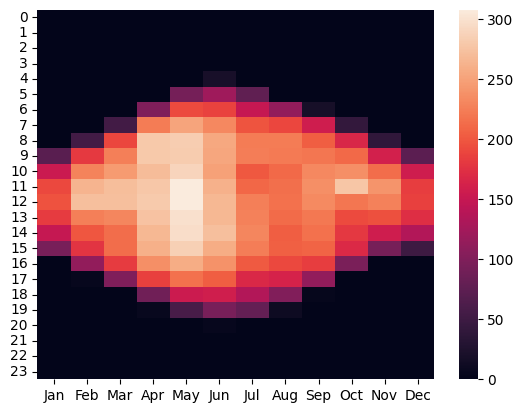

In [17]:
# Direct normal irradiation
sns.heatmap(gsa.iloc[:, 1:], cmap='rocket')
plt.show()

In [ ]:
# remove 'Unnamed' column
df = df.iloc[:, 1:]

In [ ]:
with pd.option_context('display.max_rows', None):
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96432 entries, 0 to 96431
Data columns (total 70 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   stno       96432 non-null  int64  
 1   synop_no   96432 non-null  int64  
 2   year       96432 non-null  int64  
 3   month      96432 non-null  int64  
 4   day        96432 non-null  int64  
 5   hour       96432 non-null  int64  
 6   date       96432 non-null  object 
 7   iobs       96432 non-null  int64  
 8   idir       96432 non-null  int64  
 9   dir        96432 non-null  int64  
 10  ispeed     96432 non-null  int64  
 11  speed      96432 non-null  int64  
 12  vis        96432 non-null  int64  
 13  ww         96432 non-null  int64  
 14  w          96432 non-null  int64  
 15  wwa        0 non-null      float64
 16  wa         0 non-null      float64
 17  pchar      96432 non-null  int64  
 18  ptend      96432 non-null  float64
 19  ippp       96432 non-null  int64  
 20  cbl   

## 2. Data Cleaning and Preprocessing

Steps:
- Added datetime column and index
- Added DNI from global solar atlas to the dataset
- Added 1 hr lead time fog classification target
- Added season column (Spring -> Winter)
- Replaced 999 placeholder value in cloud ceiling height with 0. 999 placeholder value could be problematic as it is an outlier
- Replaced all missing values with 0 for modelling
- Interpolated erronous outlier in wetbulb temperature variable
- Sorted non-redundant variables into lists by their types, excluding variables that are near-duplicates (e.g., speed, tabspeed -> excluded tabspeed), and supplementary WMO code variables due to their high granularity.
- Added fog formation, fog dissipation, and fog state transition variables. These will be used to assess the models' ability to predict fog transitions.
Feature Engineering:
- Added difference between air temperature and dew point temperature variable.
- Added last 12-hour rainfall rolling sum.


Notes:
- Didn't find a publicly available global solar radiation dataset of temporal resolution finer than annually. But found direct normal irradiation, which is a more localised solar energy absorption profile. Imported the DNI for Dublin Airport into our dataset.

In [ ]:
# fixing datetime column
def remove_nbsp(d):
    return d.replace(d[11:17], ' ')

df['date'] = df['date'].apply(remove_nbsp)

# add datetime index to df
df.index = pd.to_datetime(df['date'])
df.index = df.index.rename('date_time')
df.sort_values(by='date_time', inplace=True)

In [11]:
# unpivot the gsa data and create columns for joining into df
gsa_flat = pd.melt(gsa, id_vars = ['hour'], var_name='month_str', value_name='dni')


In [ ]:
month_abbrv = gsa_flat.month_str.unique().tolist()

mmap = {}
for k, v in zip(month_abbrv, range(1,13)):
  mmap[k] = v

gsa_flat['month'] = gsa_flat['month_str'].map(mmap)

In [ ]:
df = df.merge(gsa_flat[['month', 'hour', 'dni']], on=['month', 'hour'], how='left')
df.index = pd.to_datetime(df['date'])
df.index = df.index.rename('date_time')

In [ ]:
df[target]

date_time
2011-01-01 00:00:00    0
2011-01-01 01:00:00    0
2011-01-01 02:00:00    0
2011-01-01 03:00:00    0
2011-01-01 04:00:00    0
                      ..
2021-12-31 19:00:00    0
2021-12-31 20:00:00    0
2021-12-31 21:00:00    0
2021-12-31 22:00:00    0
2021-12-31 23:00:00    0
Name: target_hr1, Length: 96432, dtype: int64

In [ ]:
# create 1 hour lead time target
df['vis_hr1'] = df['vis'].shift(-1)
df['target_hr1'] = np.where(df.vis_hr1 <= 1000, 1, 0)
df['fog_state'] = np.where(df.vis <= 1000, 'fog', 'no fog')
season_map = {
    2:'spring', 3:'spring', 4:'spring',
    5:'summer', 6:'summer', 7:'summer',
    8:'autumn', 9:'autumn', 10:'autumn',
    11:'winter', 12:'winter', 1:'winter'
} 

df['season'] = df.month.map(season_map)
df['temp_dew_dist'] = df['drybulb'] - df['dewpt']

# this 12 hour rolling sum will replace rguage, which updates 12 hourly.
df['rainfall12hma'] = df.rainfall.rolling(12).sum()

# fill missing values
df.loc[df['ceiling']==999, 'ceiling'] = 0
df['ceiling'] = df['ceiling'].replace(999, 0).fillna(0)
df = df.fillna(0)

# build fog state transition variable
target='target_hr1'
formation = []
dissipation = []
fog_flag = False
for index, row in df.iterrows():
  # case 1: fog formation
  if row[target] == 1 and not fog_flag:
    formation.append(1)
    dissipation.append(0)
    fog_flag = True
  # case 2: fog dissipation
  elif row[target] == 0 and fog_flag:
    dissipation.append(1)
    formation.append(0)
    fog_flag = False
  # case 3: not a fog transition
  else:
    formation.append(0)
    dissipation.append(0)

df['fog_formation'] = formation
df['fog_dissipation'] = dissipation
df['transition'] = np.where((df.fog_formation == 1)|(df.fog_dissipation == 1), 1, 0)

target = 'target_hr1'

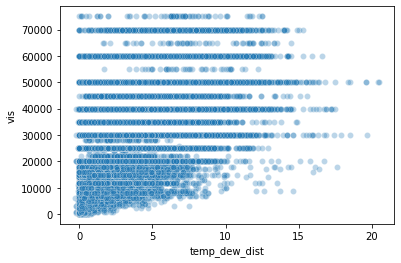

In [ ]:
# when the difference between temperature and dewpoint is small, fog is more 
# likely to occur and lower visibilities are observed!
sns.scatterplot(x='temp_dew_dist', y='vis', data=df, alpha=0.3)
plt.show()

In [ ]:
df[target].value_counts()

0    95684
1      748
Name: target_hr1, dtype: int64

In [ ]:
missing_percentages(X=df)

Empty DataFrame
Columns: [total, percentage]
Index: []


In [ ]:
# in the rainfall gauge there is a non-missing value every 12 hours, so the gauge provides 12-hourly data
# we have also an hourly rainfall variable so we'll exclude this and add a 12h
# moving average in it's place
df.rgauge.tail(6)

date_time
2021-12-31 18:00:00    0.0
2021-12-31 19:00:00    0.0
2021-12-31 20:00:00    0.0
2021-12-31 21:00:00    0.0
2021-12-31 22:00:00    0.0
2021-12-31 23:00:00    0.0
Name: rgauge, dtype: float64

In [ ]:
# cmedium and chigh cloud cover WMO variables have many missing values
# not obvious how to impute these. We'll consider these only for models that 
# handle missing values
df.chigh.value_counts()

0.0    66590
2.0    23609
1.0     5884
8.0      113
3.0       95
9.0       77
6.0       37
7.0       13
5.0       12
4.0        2
Name: chigh, dtype: int64

In [ ]:
df.cmedium.value_counts()

0.0    75732
3.0    15964
7.0     3601
2.0      646
4.0      260
1.0      102
6.0       68
8.0       57
5.0        1
9.0        1
Name: cmedium, dtype: int64

In [ ]:
indicators = [col for col in df.columns if col[0] == 'i']

## check  indicator variables
for col in indicators:
  print(df.value_counts(col))
  print("-"*30)


iobs
0    96428
2        4
dtype: int64
------------------------------
idir
0    96432
dtype: int64
------------------------------
ispeed
0    96432
dtype: int64
------------------------------
ippp
0    96432
dtype: int64
------------------------------
ittt
0    94680
1     1752
dtype: int64
------------------------------
iwb
0    93921
1     2510
5        1
dtype: int64
------------------------------
isky
0    44834
2    42635
3     8944
1       19
dtype: int64
------------------------------
idur
0    96414
3       18
dtype: int64
------------------------------
igauge
0    91697
2     2930
3     1783
8       19
1        2
4        1
dtype: int64
------------------------------
irainfall
0    75892
2    13508
3     7013
1       19
dtype: int64
------------------------------
isunshine
0    78822
2    17604
1        6
dtype: int64
------------------------------
itabdir
2    96422
6        6
0        2
4        2
dtype: int64
------------------------------
itabspeed
2    96423
6        6
4

In [ ]:
# most hours feature no rainfall, so we will impute missing values with 0
df.duration.value_counts()

0.0    75812
1.0     4163
0.1     4087
0.4     2979
0.2     2685
0.3     2084
0.9     1112
0.5      897
0.8      881
0.7      867
0.6      865
Name: duration, dtype: int64

In [ ]:
# 999 represents no reported cloud ceiling. This seems to occur frequently
# this can occur when the cloud layers are too thin to form a ceiling.
df.ceiling.value_counts()

0      23086
50      4764
40      4145
200     3917
60      3647
       ...  
52         2
57         1
65         1
168        1
61         1
Name: ceiling, Length: 79, dtype: int64

In [ ]:
# impute missing values
df['duration'] = df['duration'].fillna(0)

In [ ]:
df.loc['2011-01-08', ['rainfall', 'rainfall12hma']].head()

,rainfall,rainfall12hma
date_time,,
2011-01-08 00:00:00,0.6,10.4
2011-01-08 01:00:00,0.1,10.5
2011-01-08 02:00:00,0.0,10.5
2011-01-08 03:00:00,0.0,10.5
2011-01-08 04:00:00,0.0,10.5


In [ ]:
# wetbulb temperature of -50 degrees must be an erronous entry. 
# remove this and replace with linear interpolation
df.loc[df.wetbulb < -15, ['wetbulb', 'drybulb']]

,wetbulb,drybulb
date_time,,


In [ ]:
df.loc[df.wetbulb < -15, 'wetbulb'] = np.nan
df.wetbulb = df.wetbulb.interpolate(method='linear')

# validation
df.loc['2020-01-23 06:00:00', 'wetbulb']

5.75

In [ ]:
df.head()

,stno,synop_no,year,month,day,hour,date,iobs,idir,dir,ispeed,speed,vis,ww,w,wwa,wa,pchar,ptend,ippp,cbl,msl,ittt,drybulb,iwb,wetbulb,dewpt,vp,rh,isky,clow,cmedium,chigh,nlc,ntot,hlc,nsig1,tsig1,hsig1,nsig2,tsig2,hsig2,nsig3,tsig3,hsig3,nsig4,tsig4,hsig4,ceiling,sp1,sp2,sp3,sp4,sog,sos,dos,weather,idur,duration,igauge,rgauge,irainfall,rainfall,isunshine,sunshine,itabdir,tabdir,itabspeed,tabspeed,pweather,dni,vis_hr1,target_hr1,fog_state,season,temp_dew_dist,rainfall12hma,fog_formation,fog_dissipation,transition
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,532,0,2011,1,1,0,01-Jan-2011 00:00:00,0,0,27,0,7,9000,10,22,0.0,0.0,5,0.1,0,1017.1,1027.8,0,5.5,0,4.6,3.3,7.8,86,2,5.0,0.0,0.0,7,7,22,7,6,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,2,0.0,2,26,2,6,0,0,9000.0,0,no fog,winter,2.2,0.0,0,0,0
2011-01-01 01:00:00,532,0,2011,1,1,1,01-Jan-2011 01:00:00,0,0,28,0,6,9000,10,22,0.0,0.0,5,0.0,0,1017.1,1027.8,0,5.1,0,4.4,3.4,7.8,89,2,5.0,0.0,0.0,7,7,22,7,6,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,2,0.0,2,28,2,6,0,0,8000.0,0,no fog,winter,1.7,0.0,0,0,0
2011-01-01 02:00:00,532,0,2011,1,1,2,01-Jan-2011 02:00:00,0,0,27,0,6,8000,10,22,0.0,0.0,8,0.2,0,1016.8,1027.5,0,5.3,0,4.0,2.1,7.1,80,2,5.0,0.0,0.0,7,7,22,7,6,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,2,0.0,2,27,2,7,0,0,8000.0,0,no fog,winter,3.2,0.0,0,0,0
2011-01-01 03:00:00,532,0,2011,1,1,3,01-Jan-2011 03:00:00,0,0,25,0,7,8000,10,22,0.0,0.0,7,0.5,0,1016.6,1027.3,0,5.2,0,4.6,3.7,8.0,90,2,5.0,0.0,0.0,7,7,23,7,6,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,2,0.0,2,27,2,7,0,0,8000.0,0,no fog,winter,1.5,0.0,0,0,0
2011-01-01 04:00:00,532,0,2011,1,1,4,01-Jan-2011 04:00:00,0,0,28,0,7,8000,10,22,0.0,0.0,6,0.5,0,1016.6,1027.3,0,5.1,0,4.7,4.1,8.2,94,2,5.0,0.0,0.0,7,7,24,7,6,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,2,0.0,2,27,2,7,0,0,9000.0,0,no fog,winter,1.0,0.0,0,0,0


In [ ]:
# to keep record of variables that aren't carried into the final exported data at the end
metadata = ['date', 'date_time', 'year', 'month', 'day', 'hour', 'season']
indicator = [col for col in df.columns if col[0] == 'i']
constant = [var for var in df.columns if len(df[var].value_counts()) == 1]
codes = ['sp1', 'sp2', 'sp3', 'sp4', 'wwa', 'wa'] # 'w' ,'ww', 'pweather', 'weather'
excluded = indicator + constant + codes + ['rgauge', 'sog']
vis_vars=['target_hr1', 'vis_hr1', 'transition', 'fog_formation', 'fog_dissipation']
target = 'target_hr1'

categorical=['fog_state', 'season', 'tsig1', 'tsig2', 'tsig3', 'pchar', 'w', 'ww', 'pweather',
             'weather']
discrete = [var for var in df.columns if len(df[var].unique()) < 15 and 
             var not in excluded + categorical + metadata + codes + indicator + vis_vars]

continuous = [var for var in df.columns if var not in discrete + excluded + categorical + metadata + codes + indicator + vis_vars]
numerical = continuous+discrete
# conservative list of variables known to have an impact on fog formation.
# the other lists are too big for certain visualisations
fog_vars = ['rainfall', 'drybulb', 'cbl', 'ntot', 'dni', 'dewpt', 'speed', 'dir', 'rh']

In [ ]:
constant

['stno', 'synop_no', 'idir', 'ispeed', 'wwa', 'wa', 'ippp', 'sos']

In [ ]:
df.fog_formation.value_counts()

0    96178
1      254
Name: fog_formation, dtype: int64

In [ ]:
missing_percentages(df)

Empty DataFrame
Columns: [total, percentage]
Index: []


## 3. Fog duration dataset creation

Here we create a dataset measuring the duration of fog events for analysing fog durations

In [ ]:
# retrieve fog episode durations from the dataset
duration_dict={'date': [], 'fog_duration': [], 'min_vis': [], 'season': [], 'year': []}

fog_counter = 0
fog_flag = False
min_vis=1000
for index, row in tqdm(df.iterrows()):
  # case 1: encountered the first fog instance in a fog event
  if not fog_flag and row['vis'] <= 1000:
    fog_date = row['date']
    fog_flag = True
    season = row['season']
    year = row['year']
    
    # storing minimum visibility from fog event
    if row['vis'] < min_vis:
      min_vis = row['vis']
    fog_counter += 1
  
  # case 2: fog event was previously detected and is ongoing
  if fog_flag and row['vis'] <= 1000:
    if row['vis'] < min_vis:
      min_vis = row['vis']

    fog_counter += 1
  
  # case 3: reached the end of fog event
  if fog_flag and row['vis'] > 1000:
    duration_dict['date'].append(fog_date)
    duration_dict['fog_duration'].append(fog_counter)
    duration_dict['min_vis'].append(min_vis)
    duration_dict['season'].append(season)
    duration_dict['year'].append(year)

    if len(duration_dict['date']) != len(duration_dict['fog_duration']): print("mismatch between lengths")
    
    # after noting the fog event, continue looking for the next
    fog_counter = 0
    fog_flag = False
    min_vis = 1000

96432it [00:04, 20305.80it/s]


In [ ]:
fog_df = pd.DataFrame(duration_dict)
fog_df.index = fog_df.date
fog_df.drop(columns=['date'], inplace=True)
fog_df.index = fog_df.index.rename("date_time")

## 3. Exporting data
After adding new variables cleaning the data, we export the updated version to be used in the other notebooks.

In [ ]:
final_df = df.loc[:,[var for var in df.columns if var not in excluded]]

In [ ]:
df_train = final_df.loc[final_df.index.year < 2020]
df_test = final_df.loc[~final_df.index.isin(df_train.index)]

print("Training and validation data:", df_train.shape)
print("Test data:", df_test.shape)

Training and validation data: (78888, 56)
Test data: (17544, 56)


In [ ]:
final_df.shape

(96432, 56)

In [ ]:
# Variables selected from 04_Modelling_xgb notebook
# export preprocessed version of the data for pycaret.

vars_sel = ['vis', 'temp_dew_dist', 'rh', 'ceiling', 'duration', 'hsig2', 'dni', 
                  'dewpt', 'drybulb', 'cbl', 'hlc', 'ntot', 'speed', 'vp', 'pchar','dir']
num_vars_sel = [var for var in vars_sel if var in numerical]
cat_vars_sel = [var for var in vars_sel if var in categorical]

# creating training sets using only the selected features
X_train, X_test = preprocess(df_train, df_test, cat_vars=cat_vars_sel, num_vars=num_vars_sel, cat_encoder='oh')

y_train = df_train[target]
y_test = df_test[target]

Need to export the preprocessed train and test sets here also. This is because pycaret has dependency conflicts with the sklearn version needed for the preprocess. It also has conflicts with neptune so the pycaret notebook just imports the data and does the pycaret stuff independently.

In [ ]:
# set up paths for export
fog_duration_path = os.path.join(path, 'data/fog_duration_data.csv')
train_valid_path = os.path.join(path, 'data/train_data.csv')
test_path = os.path.join(path, 'data/test_data.csv')

# datasets of the variables we've selected thus far (to import for pycaret)
X_train_path = os.path.join(path, 'data/pycaret/X_train.csv')
y_train_path = os.path.join(path, 'data/pycaret/y_train.csv')
X_test_path = os.path.join(path, 'data/pycaret/X_test.csv')
y_test_path = os.path.join(path, 'data/pycaret/y_test.csv')


# Training/Validation and Testing data export
df_train.to_csv(train_valid_path)
df_test.to_csv(test_path)
print("Exported training/validation and testing data")
# fog duration dataset
fog_df.to_csv(fog_duration_path)
print("Exported fog duration data to", fog_duration_path)

# preprocessed data export (for pycaret)
X_train.to_csv(X_train_path)
y_train.to_csv(y_train_path)

X_test.to_csv(X_test_path)
y_test.to_csv(y_test_path)

print("Exported preprocessed data for pycaret")

Exported training/validation and testing data
Exported fog duration data to /content/drive/My Drive/DS_Modules/CA4021 (Final Year Project)/data/fog_duration_data.csv
Exported preprocessed data for pycaret


In [ ]:
# this is a test